# 주제 : 추천 시스템 - 영화 데이터셋과 Rating Matrix를 활용하여 추천 모델 학습하기
----------

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.
    
    
## 데이터 소개
    - 이번 주제는 MovieLens Dataset을 사용합니다.
    - 파일은 두 개 이며, 각각의 컬럼은 아래와 같습니다.
    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    
- 데이터 출처: https://grouplens.org/datasets/movielens/


## 최종 목표
    - CF(Collaborative Filtering) 기반 추천 모델의 이해
    - Matrix Factorization 기반 추천 모델의 이해
    - KNN, SVD 알고리즘에 대한 이해
    - 훈련된 모델의 결과를 해석하는 방법 습득
    - 모델의 추천 결과를 평가하는 방법 습득

- 출제자 : 윤기태 강사
---

## Step 1. 데이터 전처리 과정

### 문제 1. 데이터 불러오기

In [ ]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### 문제 2. EDA - 사용자 수와 영화의 수 탐색

In [ ]:
len(rating_df['user_id'].unique())

6040

In [ ]:
len(rating_df['movie_id'].unique())

3706

### 문제 3. EDA - 영화 평가 점수의 분포 탐색

In [ ]:
import matplotlib.pyplot as plt

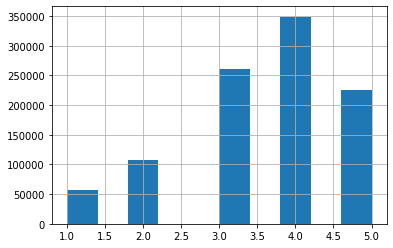

In [ ]:
rating_df['rating'].hist()

## Step 2. CF-based 모델링 (KNN)

### Rating Matrix와 Colaborative Filtering (CF)
----------

#### Rating Matrix

![rating matrix](https://www.researchgate.net/profile/Giuseppe_Manco3/publication/220907096/figure/fig1/AS:305570830667776@1449865171054/An-example-of-rating-matrix.png)

    1. User를 Row, Item을 Column으로 하며 Value를 Rating으로 하는 행렬
    2. Rating의 종류
      - Explicit Feedback : 영화 점수, 리뷰 점수, 좋아요 표시...
      - Implicit Feedback : 조회, 시청, 구매, 찜 표시...
    3. Rating Matrix를 추천 모델로 활용하는 방법
      - Colaborative Filtering (CF)
      - Matrix Factorization (MF)

-----

#### Colaborative Filtering (CF)

![CF](https://t1.daumcdn.net/cfile/tistory/9970CE495AF71C0C06)

> 고객들의 선호도와 관심 표현을 바탕으로 선호도, 관심에서 비슷한 패턴을 가진 고객들을 식별해 내는 기법이다. 비슷한 취향을 가진 고객들에게 서로 아직 구매하지 않은 상품들은 교차 추천하거나 분류된 고객의 취향이나 생활 형태에 따라 관련 상품을 추천하는 형태의 서비스를 제공하기 위해 사용된다.
    
    1. User-based
    2. Item-based

-----

### 문제 4. 모델링 - Train/Test 데이터 분리

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 4.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670931 sha256=013e833caf4ccf4b39d746b4ee7e2cf614490d80577aa26321b84d2827e6cca8
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

### 문제 5. 모델링 - KNN 모델 학습

-----

#### KNN (K-Nearest Neighbor) 알고리즘

![knn](http://i.imgur.com/gLBo1gX.png)

    [KNN의 대략적인 이해]
    1. 새로운(혹은 특정한) 데이터 포인트 X가 있을 때, X와 가장 유사한 k개를 이용하여 데이터 포인트 X의 위치를 찾는 알고리즘
    2. euclidean distance, cosine similarity 등을 기준으로 유사한 k개를 계산
    3. 분류(classification) 문제의 경우는 k개의 포인트에서 가장 많이 등장한 class로 할당
    4. 예측(regression) 문제의 경우는 k개 포인트의 평균 값, 혹은 가중치 값 등으로 X의 값을 예측

#### Surprise의 KNN

> A basic collaborative filtering algorithm. The prediction 𝑟̂ 𝑢𝑖 is set as

![suprise knn](https://drive.google.com/uc?id=1P9sMYJf2232m1Hi0ONfdHp3YT7L7AFHf)

###### (https://surprise.readthedocs.io/en/stable/knn_inspired.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. User-based CF
    2. 유저 A와 가장 영화를 유사하게 평가한 유저 k명을 선정
    3. k명의 유저가 영화 a를 평가한 점수를 활용하여 위의 식대로 점수를 계산함
    4. 이와 같은 방식으로 Rating Matrix를 완성
-----
    [Similarity]
    1. 가장 일반적인 Similarity 계산 방식은 cosine similarity
    2. 다른 방식은 euclidean distance, jaccard index, pearson correlation 등이 있음

![cosine](https://drive.google.com/uc?id=1SMNz9IKZcQpkBYHwybkjy8XsQPHANvxJ)
-----

In [ ]:
# KNN의 이해를 돕기 위한 참고 코드

aa = (0.9 * 4) + (0.8 * 3) + (0.7 * 5) + (0.6 * 1)
bb = (0.9) + (0.8) + (0.7) + (0.6)
aa/bb

3.3666666666666663

In [ ]:
from surprise import KNNBasic
from surprise import accuracy

algo = KNNBasic(k=40, min_k=1, sim_options={"user_based": True, "name": "cosine"})
algo.fit(trainset)
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 문제 6. 모델링 - RMSE 평가

In [ ]:
accuracy.rmse(predictions)

RMSE: 0.9765


0.9765173718766696

### 문제 7. 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [ ]:
predictions = algo.test(testset[:20])

for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 3108 | real rating : 4.0 | predicted rating : 4.000956164616837
Item id 2915 | real rating : 4.0 | predicted rating : 3.8749470650493367
Item id 1921 | real rating : 3.0 | predicted rating : 4.1005564782261175
Item id 3052 | real rating : 4.0 | predicted rating : 3.6000323361489097
Item id 1639 | real rating : 4.0 | predicted rating : 3.9751054998038162
Item id 2168 | real rating : 3.0 | predicted rating : 3.452749688970762
Item id 1476 | real rating : 1.0 | predicted rating : 3.701165458984087
Item id 151 | real rating : 4.0 | predicted rating : 3.7757258190072007
Item id 21 | real rating : 4.0 | predicted rating : 3.7499184933806027
Item id 3200 | real rating : 4.0 | predicted rating : 4.0509261262629614
Item id 2672 | real rating : 3.0 | predicted rating : 3.2759168102793645
Item id 1672 | real rating : 2.0 | predicted rating : 3.7256899438524576
Item id 2140 | real rating : 3.0 | predicted rating : 3.599779052041405
Item id 1061 | real rating : 2.0 | predicted rating : 3.94

## Step 3. MF-based 모델링 (SVD)

### 문제 8. 모델링 - Train/Test 데이터 분리

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

### 문제 9. 모델링 - SVD 모델 학습

-----

#### Matrix Factorization의 개념

![MF](https://t1.daumcdn.net/cfile/tistory/99EAC1455AF71F3E31)

![MF2](https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-3-319-65930-5_47/MediaObjects/455696_1_En_47_Fig3_HTML.gif)

    [MF의 대략적인 이해]
    1. 원래의 행렬을 다른 2개 행렬로 분해하고, 이를 다시 원래 모양으로 만드는 과정을 Factorization 이라고 함.
    2. 그 과정에서 Latent Factor 라는 것을 활용하여, 행과 열의 성질을 만들어낼 수 있음.
    3. latent factor를 충분히 많이 만들게 되면, 유저와 아이템의 성질을 벡터로 표현 가능.
    4. 일반적으로 지도 학습을 통해 P와 Q를 찾게 되고, 이를 Model-based CF 라고 하기도 함.

#### Surprise의 SVD

> The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization

> The prediction 𝑟̂ 𝑢𝑖 is set as:

![r_ui](https://drive.google.com/uc?id=1uwNiGIyU-2xNasLQsjRhu3unwKtawTYe)

###### (https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. Model-based MF
    2. 이미 점수가 존재하는 r_ui를 기준으로 P, Q를 학습.
    3. 특정 epoch, 혹은 수렴 조건에 달할 때 까지 학습 (Gradient Descent)

![r_ui](https://drive.google.com/uc?id=1y6mB8mkO8sJj8esH0Kt88Vw3yC1LFyon)

![r_ui](https://drive.google.com/uc?id=1SfAOjYPIbxuume7qrZ93jNIPUYih05uW)

-----

In [ ]:
from surprise import SVD
from surprise import accuracy

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

### 문제 10. 모델링 - RMSE 평가

In [ ]:
accuracy.rmse(predictions)

RMSE: 0.8762


0.8761799012203824

### 문제 11. 모델링 & 시각화 - RMSE를 개선하는 파라미터 튜닝 자동화

In [ ]:
import time

param_list = [10, 50, 100, 150, 200]
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in param_list:    
    train_start = time.time()
    algo = SVD(n_factors=n)
    algo.fit(trainset)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = algo.test(testset)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 14.20 seconds
RMSE of test dataset in SVD model, n_factors=10
RMSE: 0.8789
------------------------------------
training time of model: 29.28 seconds
RMSE of test dataset in SVD model, n_factors=50
RMSE: 0.8729
------------------------------------
training time of model: 46.31 seconds
RMSE of test dataset in SVD model, n_factors=100
RMSE: 0.8780
------------------------------------
training time of model: 62.74 seconds
RMSE of test dataset in SVD model, n_factors=150
RMSE: 0.8799
------------------------------------
training time of model: 77.55 seconds
RMSE of test dataset in SVD model, n_factors=200
RMSE: 0.8826
------------------------------------
searching n_factors is finish.


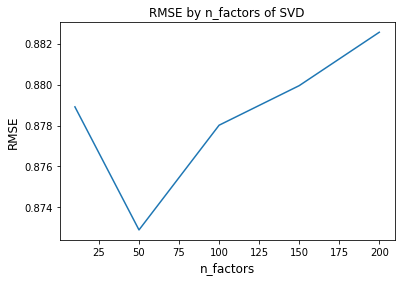

In [ ]:
plt.plot(param_list, rmse_list_by_factors)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

### 문제 12. 모델 평가 - 최종 RMSE 평가

In [ ]:
algo = SVD(n_factors=50)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8727


0.8727111942031506

### 문제 13. 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [ ]:
predictions = algo.test(testset[:20])

for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 2291 | real rating : 4.0 | predicted rating : 4.147930524736095
Item id 2805 | real rating : 3.0 | predicted rating : 3.030604759055777
Item id 2628 | real rating : 4.0 | predicted rating : 3.576898081408124
Item id 1951 | real rating : 4.0 | predicted rating : 3.891100581039247
Item id 3873 | real rating : 1.0 | predicted rating : 3.7183154686431363
Item id 2858 | real rating : 5.0 | predicted rating : 4.442367404917953
Item id 2094 | real rating : 2.0 | predicted rating : 3.187054276988139
Item id 3006 | real rating : 5.0 | predicted rating : 3.9297657708804565
Item id 2699 | real rating : 4.0 | predicted rating : 3.818381571977022
Item id 2396 | real rating : 4.0 | predicted rating : 3.47995229483787
Item id 468 | real rating : 3.0 | predicted rating : 3.0762640970755073
Item id 2734 | real rating : 3.0 | predicted rating : 4.0242197608782595
Item id 3044 | real rating : 1.0 | predicted rating : 3.695124397169422
Item id 1431 | real rating : 3.0 | predicted rating : 3.366615

## Step 4. 추천 결과 평가

-----

#### CF, MF 기반 추천시스템의 가정(한계)

    [가정 : 사용자의 과거 Preference는 미래에서도 동일하다]
    1. Time Series로 추정된 선호도가 아닌, Estimate 되거나 Factorized 된 점수
    2. A시점에 평가한 선호도와, B시점에 평가한 선호도가 동일 선에서 학습됨
    3. Test 데이터에 대한 평가 역시, 시간이 고려되지 않은 "랜덤한 빈공간 찾기" 식으로 평가됨

- 이번 챕터의 목표
  - `학습은 그렇다 치고, 평가라도 시간을 고려해서 해보자`

### 문제 14. 추천 결과 평가 - 사용자별 전체 시청리스트 추출

In [ ]:
user_watch_dict_list = rating_df.groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())

In [ ]:
user_watch_dict_list

user_id
1       [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2       [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3       [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4       [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5       [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
                              ...                        
6036    [571, 574, 2053, 2054, 2058, 588, 589, 4, 3005...
6037    [589, 3006, 1407, 2064, 2065, 593, 3015, 903, ...
6038    [1419, 920, 3088, 232, 1136, 1148, 1183, 2146,...
6039    [588, 2067, 1416, 3022, 3028, 2080, 2083, 2087...
6040    [573, 589, 1, 2068, 592, 593, 3016, 3017, 2070...
Length: 6040, dtype: object

### 문제 15. 추천 결과 평가 - 특정 시간 기준 사용자별 Train/Test 시청리스트 추출
추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

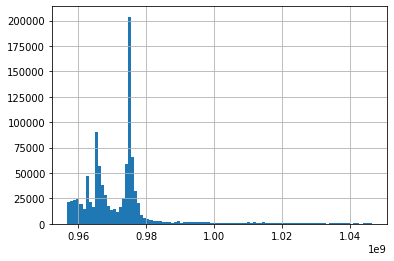

In [ ]:
rating_df['time'].hist(bins=100)

In [ ]:
rating_df['time'].quantile(q=0.8, interpolation='nearest')

975768738

In [ ]:
train_df = rating_df[rating_df['time'] < 975768738][['user_id', 'movie_id', 'rating']]
test_df = rating_df[rating_df['time'] >= 975768738][['user_id', 'movie_id', 'rating']]

In [ ]:
train_df.shape

(800164, 3)

In [ ]:
print(len(train_df['movie_id'].unique()))
print(len(test_df['movie_id'].unique()))
print(len(rating_df['movie_id'].unique()))

3662
3511
3706


In [ ]:
print(len(train_df['user_id'].unique()))
print(len(test_df['user_id'].unique()))
print(len(rating_df['user_id'].unique()))

5400
1783
6040


In [ ]:
user_watch_dict_list_test = test_df.groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())

In [ ]:
user_watch_dict_list_test

user_id
1       [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2       [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3       [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4       [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5       [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
                              ...                        
6001    [589, 1438, 965, 3481, 2875, 3147, 1552, 2917,...
6002    [3789, 3011, 1419, 3037, 902, 2098, 909, 3093,...
6016    [3795, 2062, 2065, 900, 3044, 1441, 914, 920, ...
6028                                               [3000]
6040    [2068, 953, 3421, 232, 3182, 2571, 2575, 1921,...
Length: 1783, dtype: object

### 문제 16. 추천 결과 평가 - 모델 기반 사용자별 선호 시청리스트 추출

In [ ]:
data = Dataset.load_from_df(df=train_df, reader=reader)
train_data = data.build_full_trainset()
algo = SVD(n_factors=50)
algo.fit(train_data)

In [ ]:
test_data = train_data.build_anti_testset()

In [ ]:
predictions = algo.test(test_data[:20])

for uid, iid, _, predicted_rating, _ in predictions:
    print("User id", uid, "|", "Item id", iid, "|", "predicted rating :", predicted_rating)

User id 635 | Item id 2054 | predicted rating : 3.174513075717563
User id 635 | Item id 589 | predicted rating : 4.27014720600223
User id 635 | Item id 1261 | predicted rating : 3.804535238884771
User id 635 | Item id 3016 | predicted rating : 3.5879918039445076
User id 635 | Item id 1274 | predicted rating : 3.9224069384557168
User id 635 | Item id 2094 | predicted rating : 3.4144151530354705
User id 635 | Item id 780 | predicted rating : 4.16127246657757
User id 635 | Item id 1603 | predicted rating : 3.5398990275947075
User id 635 | Item id 2288 | predicted rating : 4.116261575459194
User id 635 | Item id 968 | predicted rating : 3.622618285726042
User id 635 | Item id 2451 | predicted rating : 3.0910566976346856
User id 635 | Item id 2455 | predicted rating : 3.5131979512856306
User id 635 | Item id 1653 | predicted rating : 4.062462536927143
User id 635 | Item id 2456 | predicted rating : 2.901237580549056
User id 635 | Item id 2460 | predicted rating : 2.5728496967293077
User id 

In [ ]:
predictions = algo.test(test_data)
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in predictions:
  if uid in estimated_unwatched_dict:
    estimated_unwatched_dict[uid].append((iid, predicted_rating))
  else:
    estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

### 문제 17. 추천 결과 평가 - 예상 선호 리스트와 실제 시청리스트로 MAP@K 계산

-----

![confusion_matrix](https://drive.google.com/uc?id=1KZQaZLnxEfIvPxBLVkRPBeljUdDClMco)

    [Confusion Matrix와 Recall]
    1. 분류 문제에서 사용하는 대표적인 평가 기준
    2. 무언가의 실제 클래스(binary), 그리고 예상한 클래스(binary)를 비교하기 위한 매트릭스
    3. 이 중 Precision은 흔히 "정확도" 이라고 불리는 지표로, 맞다고 예측한 것 중에 실제로 맞는 것의 비율을 의미함.

-----

    [추천시스템과 Precision, Recall]
    1. 추천시스템에 이를 대입해보자
    2. 유저A가 실제로 시청한 영화들을 a, 모델이 유저 A가 볼 것이라고 예측한 영화들을 b라고 가정
    3. 이 때 모델이 10개의 영화를 예측 했다면 Top 10 Precision 계산할 수 있음.
    4. Recall 역시 마찬가지의 방법으로 구할 수 있음.
    5. Precision과 Recall에 대한 선택 기준은 상황마다 다르지만, 추천시스템에서 일반적으로 사용하는 지표는 "MAP"
    6. MAP(Mean Average Precision) : 추천시스템에서는 각 유저마다의 Precision을 계산한 뒤, 이것을 모든 추천 대상 유저로 확장하여 평균적인 지표를 계산한 것이라고 볼 수 있음.

In [ ]:
# 4점 이상을 준 test 시청리스트 추출
user_watch_dict_list_test = test_df[test_df['rating']>=4].groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())

In [ ]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3
for user in estimated_unwatched_dict:
  estimated_list = estimated_unwatched_dict[user].copy()
  estimated_list.sort(key=lambda tup: tup[1], reverse=True)
  try:
    top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
    actual_watch_list = user_watch_dict_list_test[int(user)]
    user_metric.append((user, top_k_prefer_list, actual_watch_list))
  except:
    print("list index out of range, exclude user " + str(user))

list index out of range, exclude user 636
list index out of range, exclude user 637
list index out of range, exclude user 638
list index out of range, exclude user 640
list index out of range, exclude user 642
list index out of range, exclude user 643
list index out of range, exclude user 644
list index out of range, exclude user 645
list index out of range, exclude user 647
list index out of range, exclude user 652
list index out of range, exclude user 653
list index out of range, exclude user 654
list index out of range, exclude user 655
list index out of range, exclude user 656
list index out of range, exclude user 657
list index out of range, exclude user 658
list index out of range, exclude user 659
list index out of range, exclude user 661
list index out of range, exclude user 662
list index out of range, exclude user 663
list index out of range, exclude user 665
list index out of range, exclude user 666
list index out of range, exclude user 668
list index out of range, exclude u

In [ ]:
# 유저 한 명의 Precision
predictive_values = user_metric[0][1]
actual_values = set(user_metric[0][2])
tp = [pv for pv in predictive_values if pv in actual_values]
len(tp) / len(predictive_values)

0.0

In [ ]:
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [ ]:
get_map(user_metric)

0.14913844325609044

### 문제 18. 추천 결과 평가 & 시각화 - K 파라미터 별 추천 결과 시각화

In [ ]:
def get_map_topk(k):
  user_metric = []
  for user in estimated_unwatched_dict:
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)
    try:
      top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
      actual_watch_list = user_watch_dict_list_test[user_watch_dict_list_test.index==user].values.tolist()[0]
      user_metric.append((user, top_k_prefer_list, actual_watch_list))
    except:
      pass
  
  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [ ]:
k_param_list = range(1,30)
map_list = []
for k in k_param_list:    
  map_list.append(get_map_topk(k))

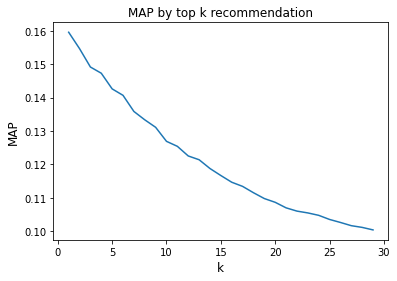

In [ ]:
plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()